### Setup

In [2]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from scipy.sparse import csr_array
from scipy.sparse import lil_array
from scipy.sparse import save_npz
from scipy.sparse import load_npz
import os
from datetime import datetime, timedelta

In [5]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1" or hostname == "blpc2":
    full_dataset_path = "/datax/scratch/nstieg/25GHz_higher.pkl"
    coherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_coherent.pkl"
    incoherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_incoherent.pkl"
elif hostname == "cosmic-gpu-1":
    full_dataset_path = "/mnt/cosmic-gpu-1/data0/nstiegle/25GHz_higher.pkl"
    coherent_dataset_path = "/mnt/cosmic-gpu-1/data0/nstiegle/25GHz_higher_coherent.pkl"
else:
    raise Exception("Data path not known")

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

In [7]:
# Load in all the distances and masks to a np array of [[distances, mask], ...] for each source
path = "/home/nstiegle/BL-COSMIC-2024-proj/frequency_adjacency/adjacent_in_each_source/" # Place to save arrays
files = os.listdir(path) # All the files and directories in the folder
files = [f for f in files if os.path.isfile(path + '/' + f)] # Just get the folders
files = [f.split('.') for f in files] # Take off the extension
files = np.array(files) # Turn into a numpy array so I can slice off the extensions
files = np.unique(files[:, 0]) # Get the unique filenames (sources observed)
sources_data = [] # Append (source.distances.npz, source.mask.npz)
sources = []
for file in files:
    distances = load_npz(path + "/" + file + ".distances.npz")
    mask = load_npz(path + "/" + file + ".mask.npz")
    sources_data.append((distances, mask))
    sources.append(file.split('_')[0])

sources_data = np.array(sources_data, dtype='object')

In [8]:
# Look at first source
# Sources are loaded in alphabetically
source_to_look_at = 0
distances = sources_data[source_to_look_at, 0]
mask = sources_data[source_to_look_at, 1]
print(sources[source_to_look_at])
grouped = coherent.groupby('source_name')
first_source = grouped.get_group(sources[source_to_look_at]).reset_index(drop=True)

2535280716217508992


In [9]:

def find_collisions_at_threshold(threshold):
    # Get those outside threshold
    outside_threshold = distances > threshold

    # Remove those outside threshold from the mask
    # We want to do mask & (~outside_threshold), but note that ~outside_threshold produces an array which is mostly true
    # So instead we'll have to do mask - outside_threshold 
    # (which does xor, so it will have values which are in mask but not outside_threshold, and those in outside_threshold but not mask)
    # Finally, to get rid of values in outside_threshold but not mask, we'll and by mask
    new_mask = mask.multiply(mask - outside_threshold)

    return new_mask

# Get hits at the exact same frequency
same_frequency = find_collisions_at_threshold(0)
hit_indices = same_frequency.nonzero()
indices_of_hits_with_collisions = np.unique(np.concatenate(hit_indices))
bool_indices_of_hits_with_collisions = np.zeros(len(first_source), dtype=bool)
bool_indices_of_hits_with_collisions[indices_of_hits_with_collisions] = True
zero_distance_dataset = first_source.iloc[bool_indices_of_hits_with_collisions]
collision_groups = zero_distance_dataset.groupby("signal_frequency")
hits_in_mixed_collision_groups = collision_groups.filter(lambda x: (0 in x["signal_drift_rate"].values) and ((x["signal_drift_rate"].abs().values != 0.0).any()))
mixed_collision_groups = hits_in_mixed_collision_groups.groupby("signal_frequency")

### Make plots

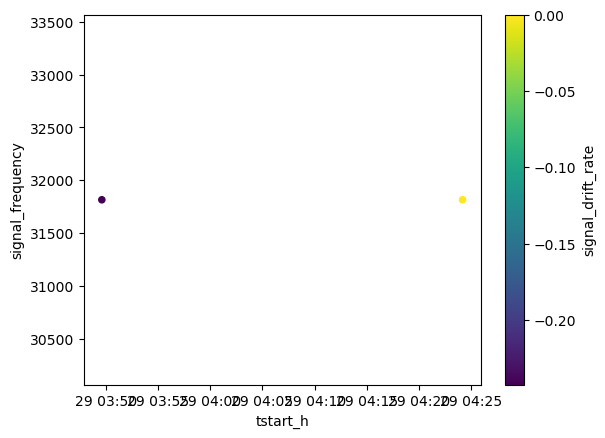

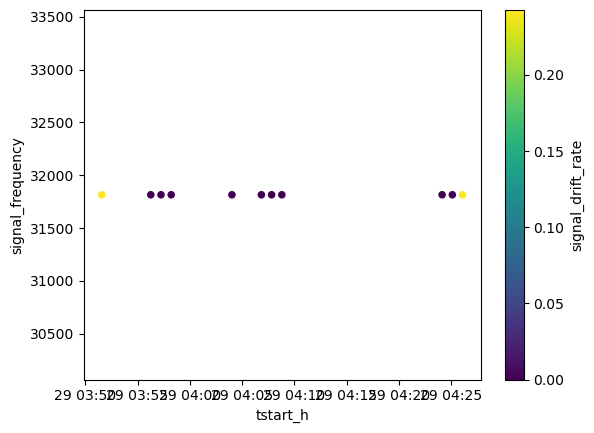

In [10]:
count = 0
thresh = 2
for frequency, group in mixed_collision_groups:
    if count < thresh:
        # print(frequency, group["signal_drift_rate"])
        group.plot.scatter("tstart_h", "signal_frequency", c="signal_drift_rate")
        count += 1
    else:
        break

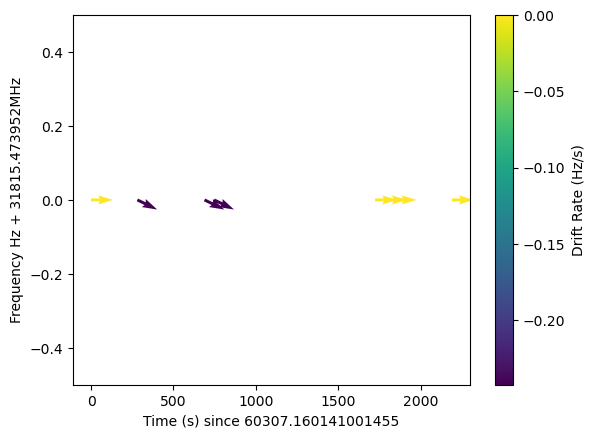

In [12]:
def quiver_plot_hits(df, color_feature=None):
    time = df["tstart"]
    t = time.iloc[0]
    frequency_mhz = df["signal_frequency"]
    f = frequency_mhz.iloc[0]
    assert(len(group["signal_frequency"].unique()) == 1)
    drift_rate_hz_s = df["signal_drift_rate"]
    # Plot the arrows at (x, y) = (time, frequency) for each point
    # Each arrow points to where the drift rate will take it in 10s
    # So if the drift rate is 2 Hz/s, then it'll point to (time + 10, frequency + 20)
    u = np.ones_like(drift_rate_hz_s)
    v = drift_rate_hz_s * 2
    magnitude = np.sqrt(u**2 + v**2)
    u_norm = u / magnitude
    v_norm = v / magnitude
    plt.quiver((time - t) * 86400, frequency_mhz - f, u_norm, v_norm, drift_rate_hz_s) #, angles='xy', scale_units='xy', scale=1) # Angles aren't exact
    cbar = plt.colorbar(label="Drift Rate (Hz/s)")
    plt.xlabel(f"Time (s) since {t}")
    plt.ylabel(f"Frequency Hz + {round(f, 6)}MHz")
    plt.ylim([-.5, .5])

quiver_plot_hits(group)